# Explore Decoupled Intelligence

This notebook investigates the **Structural Separation** hypothesis:
- Models contain distinct circuits for prompt categorization and response generation
- Categorization circuits are invariant to specific numeric inputs

Notes:
- This Colab runs on A100 GPU compute  
- Store your HuggingFace API token in the Colab HF_TOKEN secret
- Request HF access to the gated model via https://huggingface.co/meta-llama/Meta-Llama-3-8B-Instruct
- The detailed proposal/hypothesis is here https://docs.google.com/document/d/1x7n2iy1_LZXZNLQpxCzF84lZ8BEG6ZT3KWXC59erhJA
- The code base is here https://github.com/PhilipQuirke/LlmPromptCategorization

In [1]:
# CatGen (singleton) config class
class CG:
    # Model we are testing
    MODEL_NAME = "meta-llama/Meta-Llama-3-8B-Instruct" # Gated Model. Need HF_TOKEN secret. Request access via https://huggingface.co/meta-llama/Meta-Llama-3-8B-Instruct.

    # Default layer we expect to the model to use as the 'Categorization Layer'
    MODEL_LAYER = 16

    # Number of mathematical tasks we test: Max, Min, Avg, Sum, Diff, Prod
    NUM_TASKS = 6

    # We run each task using 6 times - using a different pair of numbers each time
    NUMBER_EXAMPLES = 6

    MAX_NEW_TOKENS = 30

    IN_COLAB = False

## Step 1: Import Libraries

Note that because of library mismatches to get the Colab to work you will need to 1) Run the code 2) Restart the session (when prompted) and 3) Run the code.

In [2]:
!pip install transformer-lens accelerate

In [3]:
import sys
import os
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from transformers import GPTJForCausalLM, AutoTokenizer
from transformer_lens import HookedTransformer
from sklearn.decomposition import PCA
from huggingface_hub import login
import re

In [4]:
try:
    import google.colab
    from google.colab import userdata
    CG.IN_COLAB = True
except:
    CG.IN_COLAB = False

## Step 2: Load open-source model

In [5]:
# Retrieve the token from Colab Secrets
hf_token = userdata.get('HF_TOKEN')

# Log into Hugging Face Hub
login(hf_token)

In [6]:

#model = HookedTransformer.from_pretrained(
model = HookedTransformer.from_pretrained_no_processing( # Preferred with reduced precision
    model_name=CG.MODEL_NAME,
    device="cuda" if torch.cuda.is_available() else "cpu",
    dtype="float16",              # A100 handles float16 well
    fold_ln=True,
    center_writing_weights=True,
    center_unembed=True)
    #tokenizer_pad_token=None,
    #n_devices=1 )                  # Change to >1 if sharded across GPUs

config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

Loaded pretrained model meta-llama/Meta-Llama-3-8B-Instruct into HookedTransformer


## Step 3: Define Tasks
We use the core math tasks that share identical phrasing up until the final task-identifying word .

In [7]:
tasks = ['min', 'max', 'avg', 'sum', 'diff', 'prod']

In [8]:
# We use tokens the model likely associates with the mathematical intent
task_synonyms = {
    'min': ['min', 'minimum', 'least', 'smaller', 'lesser', 'smallest'],
    'max': ['max', 'maximum', 'largest', 'biggest', 'larger'],
    'avg': ['avg', 'average', 'mean', 'median'],
    'sum': ['sum', 'add', 'plus', 'total', 'addition', 'aggregate'],
    'diff': ['diff', 'difference', 'minus', 'subtract', 'subtraction'],
    'prod': ['prod', 'product', 'multiply', 'multiplication', 'times']
}

In [9]:
# Prompt structure uses few-shot examples to improve model answer conciseness
min_prefix = "Q: What is 5 and 7 min? A: 5\nQ: What is 4 and 3 min? A: 3\nQ:"
max_prefix = "Q: What is 5 and 7 max? A: 7\nQ: What is 4 and 3 max? A: 4\nQ:"
avg_prefix = "Q: What is 5 and 9 avg? A: 7\nQ: What is 1 and 9 avg? A: 5\nQ:"
sum_prefix = "Q: What is 5 and 5 sum? A: 10\nQ: What is 2 and 2 sum? A: 4\nQ:"
diff_prefix = "Q: What is 5 and 7 diff? A: 2\nQ: What is 2 and 8 diff? A: 6\nQ:"
prod_prefix = "Q: What is 5 and 3 prod? A: 15\nQ: What is 2 and 6 prod? A: 12\nQ:"

In [10]:
test_data_1 = [
    {"prompt": f"{min_prefix} Given 21 and 39 what is the minimum?", "task": "min", "gt": "21", "x":"21", "y":"39"},
    {"prompt": f"{min_prefix} Given 11 & 23 what is the smallest?", "task": "min", "gt": "11", "x":"11", "y":"23"},
    {"prompt": f"{min_prefix} Given 65 and 49 what is the minimum?", "task": "min", "gt": "49", "x":"65", "y":"49"},
    {"prompt": f"{min_prefix} Given 32 and 11 which is lesser?", "task": "min", "gt": "11", "x":"32", "y":"11"},
    {"prompt": f"{min_prefix} Given 19 or 12 which is smallest?", "task": "min", "gt": "12", "x":"19", "y":"12"},
    {"prompt": f"{min_prefix} Given 17 and 23 which is minimum?", "task": "min", "gt": "17", "x":"17", "y":"23"},

    {"prompt": f"{max_prefix} Given 13 and 3 what is the maximum?", "task": "max", "gt": "13", "x":"13", "y":"3"},
    {"prompt": f"{max_prefix} Given 15 & 13 which is the largest?", "task": "max", "gt": "15", "x":"15", "y":"13"},
    {"prompt": f"{max_prefix} Given 22 and 36 what is the biggest?", "task": "max", "gt": "36", "x":"22", "y":"36"},
    {"prompt": f"{max_prefix} Given 48 or 32 what is the largest?", "task": "max", "gt": "48", "x":"48", "y":"32"},
    {"prompt": f"{max_prefix} Given 19 and 12 what is the maximum?", "task": "max", "gt": "19", "x":"19", "y":"12"},
    {"prompt": f"{max_prefix} Given 18 and 12 what is the largest?", "task": "max", "gt": "18", "x":"18", "y":"12"},

    {"prompt": f"{avg_prefix} Given 25 and 9 what is the average?", "task": "avg", "gt": "17", "x":"25", "y":"9"},
    {"prompt": f"{avg_prefix} Given 14 & 4 what is the avg?", "task": "avg", "gt": "9", "x":"14", "y":"4"},
    {"prompt": f"{avg_prefix} Given 11 and 47 what is the mean?", "task": "avg", "gt": "29", "x":"11", "y":"47"},
    {"prompt": f"{avg_prefix} Given 54 and 12 what is the average?", "task": "avg", "gt": "33", "x":"54", "y":"12"},
    {"prompt": f"{avg_prefix} Given 9 & 13 what is the mean?", "task": "avg", "gt": "11", "x":"9", "y":"13"},
    {"prompt": f"{avg_prefix} Given 8 and 22 what is the average?", "task": "avg", "gt": "15", "x":"8", "y":"22"},

    {"prompt": f"{sum_prefix} Given 25 and 9 what is the sum?", "task": "sum", "gt": "34", "x":"25", "y":"9"},
    {"prompt": f"{sum_prefix} Given 14 & 3 what is the total?", "task": "sum", "gt": "17", "x":"14", "y":"3"},
    {"prompt": f"{sum_prefix} Given 12 and 47 what is the total?", "task": "sum", "gt": "59", "x":"12", "y":"47"},
    {"prompt": f"{sum_prefix} Given 55 and 12 what is the aggregate?", "task": "sum", "gt": "67", "x":"55", "y":"12"},
    {"prompt": f"{sum_prefix} Given 9 and 13 what is the aggregate?", "task": "sum", "gt": "22", "x":"9", "y":"13"},
    {"prompt": f"{sum_prefix} Given 8 and 22 what is the sum?", "task": "sum", "gt": "30", "x":"8", "y":"22"},

    {"prompt": f"{diff_prefix} Given 15 and 9 what is the difference?", "task": "diff", "gt": "6", "x":"15", "y":"9"},
    {"prompt": f"{diff_prefix} Given 14 & 3 what is the diff?", "task": "diff", "gt": "11", "x":"14", "y":"3"},
    {"prompt": f"{diff_prefix} Given 12 and 40 return the delta?", "task": "diff", "gt": "28", "x":"12", "y":"40"},
    {"prompt": f"{diff_prefix} Given 55 and 12 what is the delta?", "task": "diff", "gt": "43", "x":"55", "y":"12"},
    {"prompt": f"{diff_prefix} Given 19 & 13 what is the difference?", "task": "diff", "gt": "6", "x":"19", "y":"13"},
    {"prompt": f"{diff_prefix} Given 8 and 22 what is the diff?", "task": "diff", "gt": "14", "x":"8", "y":"22"},

    {"prompt": f"{prod_prefix} Given 5 and 9 what is the product?", "task": "prod", "gt": "45", "x":"15", "y":"9"},
    {"prompt": f"{prod_prefix} Given 14 & 3, what is the multiplication?", "task": "prod", "gt": "42", "x":"14", "y":"3"},
    {"prompt": f"{prod_prefix} Given 12 and 40, what is the product?", "task": "prod", "gt": "480", "x":"12", "y":"40"},
    {"prompt": f"{prod_prefix} Given 55 by 3, what is the total multiply?", "task": "prod", "gt": "165", "x":"55", "y":"13"},
    {"prompt": f"{prod_prefix} Given 19 and 3, what is the multiply?", "task": "prod", "gt": "57", "x":"19", "y":"11"},
    {"prompt": f"{prod_prefix} Given 8 and 22 what is the total product?", "task": "prod", "gt": "176", "x":"8", "y":"22"},
]

In [11]:
test_data_2 = [
    {"prompt": f"{min_prefix} What is 21 and 39 minimum?", "task": "min", "gt": "21", "x":"21", "y":"39"},
    {"prompt": f"{min_prefix} What is 11 & 23 smallest?", "task": "min", "gt": "11", "x":"11", "y":"23"},
    {"prompt": f"{min_prefix} What is 65 and 49 minimum?", "task": "min", "gt": "49", "x":"65", "y":"49"},
    {"prompt": f"{min_prefix} For 32 and 11 which is lesser?", "task": "min", "gt": "11", "x":"32", "y":"11"},
    {"prompt": f"{min_prefix} For 19 or 12 which is smallest?", "task": "min", "gt": "12", "x":"19", "y":"12"},
    {"prompt": f"{min_prefix} Given 17 and 23 which is minimum?", "task": "min", "gt": "17", "x":"17", "y":"23"},

    {"prompt": f"{max_prefix} For 13 and 3 return the maximum?", "task": "max", "gt": "13", "x":"13", "y":"3"},
    {"prompt": f"{max_prefix} Given 15 & 13 which is the largest?", "task": "max", "gt": "15", "x":"15", "y":"13"},
    {"prompt": f"{max_prefix} For 22 and 36 return biggest?", "task": "max", "gt": "36", "x":"22", "y":"36"},
    {"prompt": f"{max_prefix} Which of 48 or 32 is largest?", "task": "max", "gt": "48", "x":"48", "y":"32"},
    {"prompt": f"{max_prefix} For 19 and 12 what is max?", "task": "max", "gt": "19", "x":"19", "y":"12"},
    {"prompt": f"{max_prefix} Given 18 and 12 what is largest?", "task": "max", "gt": "18", "x":"18", "y":"12"},

    {"prompt": f"{avg_prefix} Given 25 and 9 what is the average?", "task": "avg", "gt": "17", "x":"25", "y":"9"},
    {"prompt": f"{avg_prefix} Given 14 & 4 what is the avg?", "task": "avg", "gt": "9", "x":"14", "y":"4"},
    {"prompt": f"{avg_prefix} For 11 and 47 what is the mean?", "task": "avg", "gt": "29", "x":"11", "y":"47"},
    {"prompt": f"{avg_prefix} For 54 and 12 what is the average?", "task": "avg", "gt": "33", "x":"54", "y":"12"},
    {"prompt": f"{avg_prefix} For 9 & 13 what is the mean?", "task": "avg", "gt": "11", "x":"9", "y":"13"},
    {"prompt": f"{avg_prefix} Given 8 and 22 what is the average?", "task": "avg", "gt": "15", "x":"8", "y":"22"},

    {"prompt": f"{sum_prefix} Given 25 and 9 what is the sum?", "task": "sum", "gt": "34", "x":"25", "y":"9"},
    {"prompt": f"{sum_prefix} Given 14 & 3 what is the total?", "task": "sum", "gt": "17", "x":"14", "y":"3"},
    {"prompt": f"{sum_prefix} For 12 and 47, perform addition?", "task": "sum", "gt": "59", "x":"12", "y":"47"},
    {"prompt": f"{sum_prefix} For 55 and 12 what is the sum?", "task": "sum", "gt": "67", "x":"55", "y":"12"},
    {"prompt": f"{sum_prefix} What is 9 and 13 summed?", "task": "sum", "gt": "22", "x":"9", "y":"13"},
    {"prompt": f"{sum_prefix} Given 8 and 22 return the total?", "task": "sum", "gt": "30", "x":"8", "y":"22"},

    {"prompt": f"{diff_prefix} Given 15 and 9 what is the difference?", "task": "diff", "gt": "6", "x":"15", "y":"9"},
    {"prompt": f"{diff_prefix} Given 14 & 3 what is the diff?", "task": "diff", "gt": "11", "x":"14", "y":"3"},
    {"prompt": f"{diff_prefix} For 12 and 40 return the delta?", "task": "diff", "gt": "28", "x":"12", "y":"40"},
    {"prompt": f"{diff_prefix} For 55 and 12 what is the delta?", "task": "diff", "gt": "43", "x":"55", "y":"12"},
    {"prompt": f"{diff_prefix} For 19 & 13 find the difference?", "task": "diff", "gt": "6", "x":"19", "y":"13"},
    {"prompt": f"{diff_prefix} Given 8 and 22 what is the diff?", "task": "diff", "gt": "14", "x":"8", "y":"22"},

    {"prompt": f"{prod_prefix} Given 5 and 9 what is the product?", "task": "prod", "gt": "45", "x":"15", "y":"9"},
    {"prompt": f"{prod_prefix} With 14 & 3, do multiplication?", "task": "prod", "gt": "42", "x":"14", "y":"3"},
    {"prompt": f"{prod_prefix} For 12 and 40, what is product?", "task": "prod", "gt": "480", "x":"12", "y":"40"},
    {"prompt": f"{prod_prefix} For 55 by 3, perform multiply?", "task": "prod", "gt": "165", "x":"55", "y":"13"},
    {"prompt": f"{prod_prefix} With 19 and 3, multiply?", "task": "prod", "gt": "57", "x":"19", "y":"11"},
    {"prompt": f"{prod_prefix} Given 8 and 22 return the product?", "task": "prod", "gt": "176", "x":"8", "y":"22"},
]

In [12]:
test_data_3 = [
    {"prompt": f"{min_prefix} Minimum of 21 and 39", "task": "min", "gt": "21", "x":"21", "y":"39"},
    {"prompt": f"{min_prefix} Least of 11 & 23", "task": "min", "gt": "11", "x":"11", "y":"23"},
    {"prompt": f"{min_prefix} Min of 65 and 49", "task": "min", "gt": "49", "x":"65", "y":"49"},
    {"prompt": f"{min_prefix} Which is lesser 32 or 11?", "task": "min", "gt": "11", "x":"32", "y":"11"},
    {"prompt": f"{min_prefix} Which is less 19 or 12?", "task": "min", "gt": "12", "x":"19", "y":"12"},
    {"prompt": f"{min_prefix} Given 17 and 23 what is the littler", "task": "min", "gt": "17", "x":"17", "y":"23"},

    {"prompt": f"{max_prefix} For 13 and 3 return the maximum", "task": "max", "gt": "13", "x":"13", "y":"3"},
    {"prompt": f"{max_prefix} Given 15 & 13 which is the largest", "task": "max", "gt": "15", "x":"15", "y":"13"},
    {"prompt": f"{max_prefix} Bigger of 22 and 36", "task": "max", "gt": "36", "x":"22", "y":"36"},
    {"prompt": f"{max_prefix} Which of 48 or 32 is larger?", "task": "max", "gt": "48", "x":"48", "y":"32"},
    {"prompt": f"{max_prefix} What is max of 19 and 12?", "task": "max", "gt": "19", "x":"19", "y":"12"},
    {"prompt": f"{max_prefix} Given 18 and 12 what is biggest", "task": "max", "gt": "18", "x":"18", "y":"12"},

    {"prompt": f"{avg_prefix} Given 25 and 9 what is the average", "task": "avg", "gt": "17", "x":"25", "y":"9"},
    {"prompt": f"{avg_prefix} Given 14 & 4 what is the avg", "task": "avg", "gt": "9", "x":"14", "y":"4"},
    {"prompt": f"{avg_prefix} Mean of 11 and 47", "task": "avg", "gt": "29", "x":"11", "y":"47"},
    {"prompt": f"{avg_prefix} What is average of 54 and 12?", "task": "avg", "gt": "33", "x":"54", "y":"12"},
    {"prompt": f"{avg_prefix} What is mean of 9 & 13?", "task": "avg", "gt": "11", "x":"9", "y":"13"},
    {"prompt": f"{avg_prefix} Given 8 and 22 what is the average", "task": "avg", "gt": "15", "x":"8", "y":"22"},

    {"prompt": f"{sum_prefix} Given 25 and 9 what is the sum", "task": "sum", "gt": "34", "x":"25", "y":"9"},
    {"prompt": f"{sum_prefix} Given 14 & 3 what is the total", "task": "sum", "gt": "17", "x":"14", "y":"3"},
    {"prompt": f"{sum_prefix} Add 12 and 47", "task": "sum", "gt": "59", "x":"12", "y":"47"},
    {"prompt": f"{sum_prefix} What is 55 plus 12?", "task": "sum", "gt": "67", "x":"55", "y":"12"},
    {"prompt": f"{sum_prefix} What is 9 + 13?", "task": "sum", "gt": "22", "x":"9", "y":"13"},
    {"prompt": f"{sum_prefix} Given 8 and 22 what is the sum", "task": "sum", "gt": "30", "x":"8", "y":"22"},

    {"prompt": f"{diff_prefix} Given 15 and 9 what is the difference", "task": "diff", "gt": "6", "x":"15", "y":"9"},
    {"prompt": f"{diff_prefix} Given 14 & 3 what is the diff", "task": "diff", "gt": "11", "x":"14", "y":"3"},
    {"prompt": f"{diff_prefix} Difference beween 12 and 40", "task": "diff", "gt": "28", "x":"12", "y":"40"},
    {"prompt": f"{diff_prefix} What is 55 minus 12?", "task": "diff", "gt": "43", "x":"55", "y":"12"},
    {"prompt": f"{diff_prefix} What is 19 less 13?", "task": "diff", "gt": "6", "x":"19", "y":"13"},
    {"prompt": f"{diff_prefix} Given 8 and 22 what is the diff", "task": "diff", "gt": "14", "x":"8", "y":"22"},

    {"prompt": f"{prod_prefix} Given 5 and 9 what is the product", "task": "prod", "gt": "45", "x":"15", "y":"9"},
    {"prompt": f"{prod_prefix} Given 14 & 3, multiple them", "task": "prod", "gt": "42", "x":"14", "y":"3"},
    {"prompt": f"{prod_prefix} Product of 12 and 40", "task": "prod", "gt": "480", "x":"12", "y":"40"},
    {"prompt": f"{prod_prefix} Multiple 55 by 13?", "task": "prod", "gt": "715", "x":"55", "y":"13"},
    {"prompt": f"{prod_prefix} Product of 19 and 3?", "task": "prod", "gt": "57", "x":"19", "y":"11"},
    {"prompt": f"{prod_prefix} Given 8 and 22 calculate the product", "task": "prod", "gt": "176", "x":"8", "y":"22"},
]

In [13]:
# Select the test data set to use
test_data = test_data_1

In [14]:
assert len(tasks) == CG.NUM_TASKS
assert len(test_data) == CG.NUM_TASKS * CG.NUMBER_EXAMPLES
for d in test_data:
    assert d['task'] in tasks

In [15]:
# Generate the prompt list using the new test_data structure
all_prompts = []
metadata = []

for item in test_data:
    all_prompts.append(item['prompt'])
    metadata.append({"task": item['task'], "pair": f"({item['x']},{item['y']})", "gt": item['gt']})

print(all_prompts[0:5])
print(metadata[0:5])

['Q: What is 5 and 7 min? A: 5\nQ: What is 4 and 3 min? A: 3\nQ: Given 21 and 39 what is the minimum?', 'Q: What is 5 and 7 min? A: 5\nQ: What is 4 and 3 min? A: 3\nQ: Given 11 & 23 what is the smallest?', 'Q: What is 5 and 7 min? A: 5\nQ: What is 4 and 3 min? A: 3\nQ: Given 65 and 49 what is the minimum?', 'Q: What is 5 and 7 min? A: 5\nQ: What is 4 and 3 min? A: 3\nQ: Given 32 and 11 which is lesser?', 'Q: What is 5 and 7 min? A: 5\nQ: What is 4 and 3 min? A: 3\nQ: Given 19 or 12 which is smallest?']
[{'task': 'min', 'pair': '(21,39)', 'gt': '21'}, {'task': 'min', 'pair': '(11,23)', 'gt': '11'}, {'task': 'min', 'pair': '(65,49)', 'gt': '49'}, {'task': 'min', 'pair': '(32,11)', 'gt': '11'}, {'task': 'min', 'pair': '(19,12)', 'gt': '12'}]


## Step 4. Check Baseline Accuracy
If model can't answer the above prompts correctly, then it may not have categorization or generation circuits for the task concepts, making investigation useless.

In [19]:
def _is_last_number_close(last_number: str, ground_truth: str) -> bool:
    try:
        return abs(float(last_number) - float(ground_truth)) < 0.001
    except (ValueError, TypeError):
        return False


def is_ground_truth_correct(answer: str, ground_truth: str) -> bool:
    """
    Returns True if the ground_truth appears as the final number in the answer, ignoring whitespace and punctuation.
    Accepts answers like '13', '13.', '13**', 'The answer is 13', '**13**', 'random text **13** random text', 'boxed{13}'.
    """

    # Remove trailing whitespace and punctuation
    answer_clean = answer.strip().rstrip('.!**')
    # Find all numbers in the answer (including negative numbers and those with commas)
    numbers = re.findall(r'-?[\d,]+', answer_clean)

    # Remove commas from the numbers for comparison
    numbers_clean = [num.replace(',', '') for num in numbers]

    answer_no_comma = " " + answer.replace(",", "") + " "

    return (
        ground_truth == answer_no_comma or
        "**"+ground_truth+"**" in answer or
        "boxed{"+ground_truth+"}" in answer or
        " "+ground_truth+" " in answer_no_comma  or
        " "+ground_truth+"\n" in answer_no_comma  or
        " "+ground_truth+")" in answer_no_comma  or
        " "+ground_truth+"." in answer_no_comma  or
        (
            numbers_clean and
            _is_last_number_close(numbers_clean[-1], ground_truth)
        )
    )

In [20]:
def check_baseline_accuracy(data):
    print("Checking baseline accuracy:")

    results = []
    for i, d in enumerate(data):
      # Generate output
      output = model.generate(d["prompt"], max_new_tokens=CG.MAX_NEW_TOKENS, stop_at_eos=True, verbose=False)

      # Simple parsing to check if the ground truth is in the generated text
      clean_output = output.replace(d["prompt"], "").strip()
      is_correct = is_ground_truth_correct(clean_output, d["gt"])

      results.append({"prompt": d["prompt"][-35:], "output": clean_output[:25], "correct": bool(is_correct)})

    accuracy_df = pd.DataFrame(results)
    correct_answers_count = accuracy_df['correct'].sum()
    total_answers_count = len(accuracy_df)

    print(f"Accuracy: {correct_answers_count} of {total_answers_count} = {correct_answers_count / total_answers_count * 100:.2f}%")

    pd.set_option('display.width', 100)
    print(accuracy_df[['prompt', 'output', 'correct']])


check_baseline_accuracy(test_data)

Checking baseline accuracy:
Accuracy: 35 of 36 = 97.22%
                                  prompt                       output  correct
0    iven 21 and 39 what is the minimum?   A: 3\nTry solving it step     False
1    Given 11 & 23 what is the smallest?   A: 11\nQ: What is 9 – 8? A     True
2    iven 65 and 49 what is the minimum?   A: 49\nThis response demon     True
3    Q: Given 32 and 11 which is lesser?   A: 11\nQ: What is greater      True
4    : Given 19 or 12 which is smallest?  A: 12\n\nFinal Answer: The      True
5    : Given 17 and 23 which is minimum?   A: 17\nQ: About which numb     True
6    Given 13 and 3 what is the maximum?   A: 13\nQ: What is 8 and 2      True
7    Given 15 & 13 which is the largest?   A: 15\nQ: What is the max      True
8    iven 22 and 36 what is the biggest?   A: 36\nQ: Given 3 and 1 wh     True
9    Given 48 or 32 what is the largest?   A: 48\nQ: What is 8 and 9      True
10   iven 19 and 12 what is the maximum?   A: 19\nQ: What is 2 and 6      T

## Step 5: Layer-wise Separation Profile

Here we evaluate the layer that the categorization occurs at. In many models like GPT-NeoX or GPT-J, this typically occurs in the middle-to-late layers (e.g., layers 8–16 of 28).

- Intra-task Similarity (Blue Line): This represents the "Stability" of the categorization. According to your Structural Separation hypothesis, this should rise sharply and stay high once the model has recognized the "intent" (e.g., "summing"), regardless of the numbers provided.

- Inter-task Similarity (Red Line): This represents the "Ambiguity" between tasks. Ideally, this should remain low. If this line rises alongside the blue line, the model is seeing "mathematical intent" but failing to distinguish "sum" from "product."

- The Gating Point: You are looking for the point where the Blue line is highest and the Red line is lowest.

The lines diverge early, suggesting Categorization Circuit maybe simple (likely just keyword detection). However the divergence generally increases over layers, suggesting additional confidence is gained over time. Overall this graph is not as informative as we had hoped it would be.

Analyzing layer-wise separation profile...


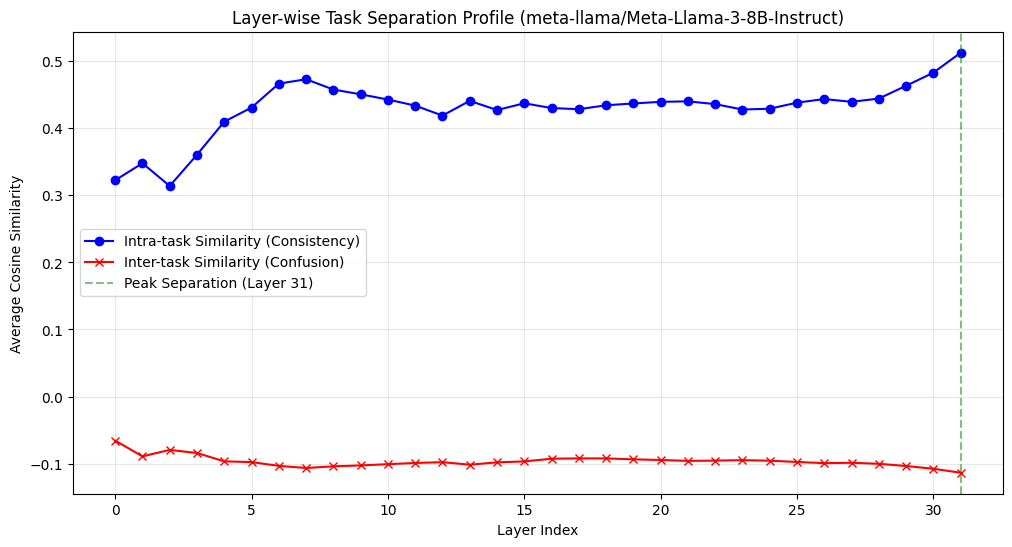

Analysis Complete. The highest separation between tasks was observed at Layer 31.


In [21]:
def visualize_layerwise_separation_profile():

    # Initialize storage for metrics
    layer_indices = range(model.cfg.n_layers)
    intra_task_sims = []
    inter_task_sims = []

    print("Analyzing layer-wise separation profile...")

    # 1. Loop through all layers in the model
    for layer_idx in layer_indices:
        layer_activations = []

        # Extract activations for all prompts at the current layer
        for prompt in all_prompts:
            with torch.no_grad():
                # Note: We use the same cache logic as Step 4 but iterate through layers
                _, cache = model.run_with_cache(prompt, names_filter=lambda name: name.endswith("resid_post"))
                vec = cache["resid_post", layer_idx][0, -1, :].detach().cpu()
                layer_activations.append(vec)

        # Convert list to tensor: [NUM_TASKS * NUMBER_EXAMPLES, d_model]
        layer_tensor = torch.stack(layer_activations)

        # Calculate Centroid-Subtracted (Task-Specific) Vectors for this layer
        layer_centroid = layer_tensor.mean(dim=0)
        layer_specific = layer_tensor - layer_centroid

        # Normalize for cosine similarity calculation
        norm_layer = F.normalize(layer_specific, p=2, dim=1)

        # Calculate the full similarity matrix [25, 25] for this layer
        sim_matrix = torch.mm(norm_layer, norm_layer.t())

        # 2. Calculate Intra-task similarity
        # How similar are different number pairs within the same task block (diagonal 5x5 blocks)?
        intra_sim_vals = []
        for t in range(CG.NUM_TASKS):
            start_idx = t * CG.NUMBER_EXAMPLES
            end_idx = start_idx + CG.NUMBER_EXAMPLES
            # Extract the 5x5 sub-matrix for this task
            block = sim_matrix[start_idx:end_idx, start_idx:end_idx]
            # Get values excluding the self-similarity diagonal (which is always 1.0)
            mask = ~torch.eye(CG.NUMBER_EXAMPLES, dtype=bool)
            intra_sim_vals.append(block[mask].mean())

        avg_intra_sim = torch.stack(intra_sim_vals).mean().item()
        intra_task_sims.append(avg_intra_sim)

        # 3. Calculate Inter-task similarity
        # How similar are different tasks to each other (off-diagonal regions)?
        all_pairs_mask = torch.ones_like(sim_matrix, dtype=bool)
        for t in range(CG.NUM_TASKS):
            start_idx = t * CG.NUMBER_EXAMPLES
            end_idx = start_idx + CG.NUMBER_EXAMPLES
            # Mask out the diagonal intra-task blocks
            all_pairs_mask[start_idx:end_idx, start_idx:end_idx] = False

        avg_inter_sim = sim_matrix[all_pairs_mask].mean().item()
        inter_task_sims.append(avg_inter_sim)

    # 4. Visualization
    plt.figure(figsize=(12, 6))
    plt.plot(layer_indices, intra_task_sims, label='Intra-task Similarity (Consistency)', marker='o', color='blue')
    plt.plot(layer_indices, inter_task_sims, label='Inter-task Similarity (Confusion)', marker='x', color='red')

    # Identify the "Categorization Layer" (Maximum Gap)
    gap = [intra - inter for intra, inter in zip(intra_task_sims, inter_task_sims)]
    best_layer = gap.index(max(gap))
    plt.axvline(x=best_layer, linestyle='--', color='green', alpha=0.5, label=f'Peak Separation (Layer {best_layer})')

    plt.title(f"Layer-wise Task Separation Profile ({CG.MODEL_NAME})")
    plt.xlabel("Layer Index")
    plt.ylabel("Average Cosine Similarity")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    print(f"Analysis Complete. The highest separation between tasks was observed at Layer {best_layer}.")
    return best_layer


CG.MODEL_LAYER = visualize_layerwise_separation_profile()

## Step 6: Extract Residual Stream Activations
To isolate the "Categorization Layer", you should extract the activations from the residual stream at the final token position across all layers. The final token (the task word) is where the categorization is finalized.

In [22]:
model_prompt_act = []
model_answers = []

for prompt in all_prompts:
    with torch.no_grad():
        # Extract activations for the categorization layer analysis using run_with_cache
        logits_for_activations, cache = model.run_with_cache(prompt)
        vec = cache["resid_post", CG.MODEL_LAYER][0, -1, :].detach().cpu()
        model_prompt_act.append(vec)

        # Generate a sequence of tokens for the model's answer
        input_ids = model.tokenizer.encode(prompt, return_tensors='pt').to(model.cfg.device)
        # Generate up to 10 new tokens for the answer. Using do_sample=False for deterministic output.
        generated_output_ids = model.generate(
            input_ids,
            max_new_tokens=10, # Allow up to 10 new tokens to cover ~35 characters
            do_sample=False,   # For deterministic answers for mathematical tasks
            temperature=0.0    # Set temperature to 0.0 for greedy decoding
            # Removed pad_token_id as it's not accepted by HookedTransformer.generate() for this model
        )

        # Decode only the newly generated part of the output
        generated_answer_tokens = generated_output_ids[0, len(input_ids[0]):]
        predicted_answer = model.tokenizer.decode(generated_answer_tokens, skip_special_tokens=True).strip()
        model_answers.append(predicted_answer)

model_prompt_tensor = torch.stack(model_prompt_act)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [23]:
print(model_answers[0:5])

['A: 21\nQ: What is', 'A: 11\nQ: What is', 'A: 49\nQ: What is', 'A: 11\nQ: What is', 'A: 12\nQ: What is']


## Step 7: Disentangling Categorization from Data

We subtract the average prompt "template" to find the task-specific vectors

In [24]:
# Calculate global mean (centroid) to remove template bias
global_centroid = model_prompt_tensor.mean(dim=0)
task_specific_vectors = model_prompt_tensor - global_centroid

## Step 8: Visualization: Similarity Heatmap

A powerful way to visualize this disentanglement is to create a similarity heatmap of all prompts (NUM_TASKS × NUMBER_EXAMPLES)

Intra-Task Consistency: Each 6x6 block represents a task (e.g., all "sum" prompts).The 6x6 blocks on the heatmap diagonal show how similar "sum (25,9)" is to "sum (99,1)". High similarity here confirms the categorization circuit is ignoring numeric (input) noise.

Inter-Task Orthogonality: The dark regions between blocks represent the separation between tasks. Different activations for different tasks => clear categorization between tasks.

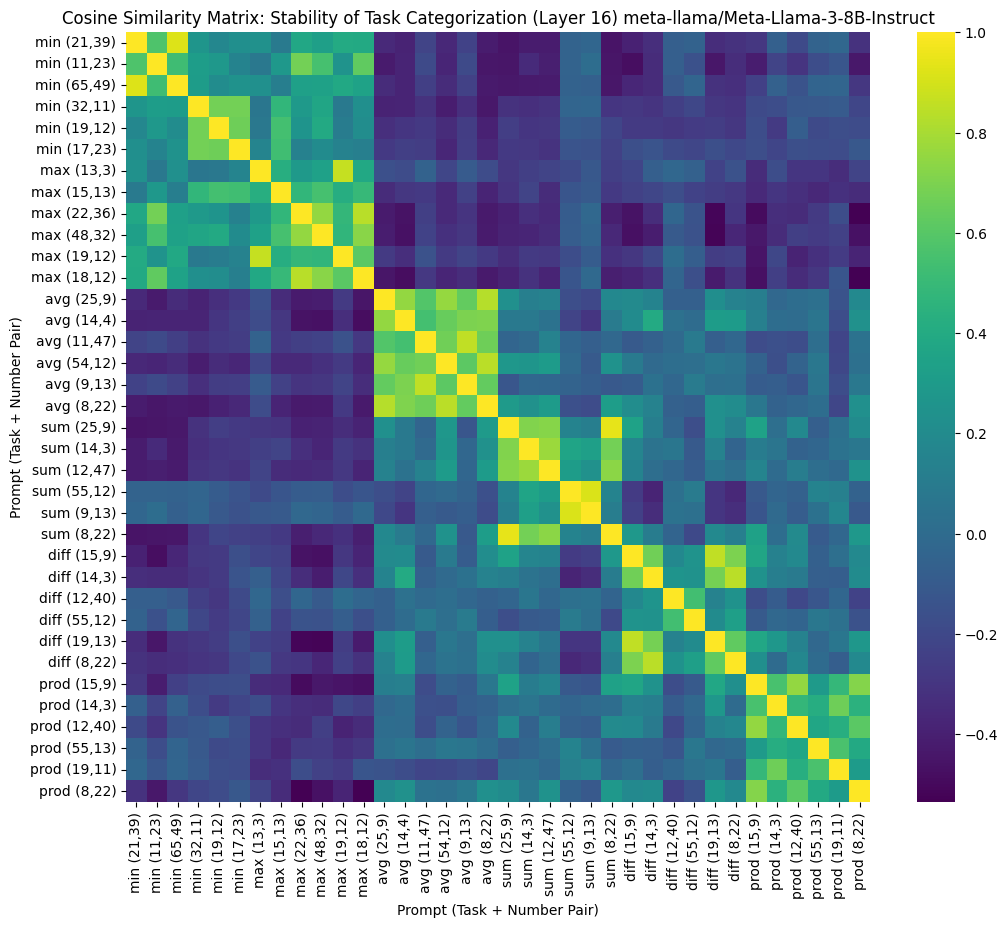

In [25]:
# Later code will show that interesting neurons at layers 14 and 16 are important in categorization.
# So we choose layer 16. Other layers give similar results.
CG.MODEL_LAYER = 16


def visualize_similarity_heatmap():

    # Normalize for cosine similarity
    norm_vecs = F.normalize(task_specific_vectors, p=2, dim=1)
    sim_matrix = torch.mm(norm_vecs, norm_vecs.t()).numpy()

    plt.figure(figsize=(12, 10))
    labels = [f"{m['task']} {m['pair']}" for m in metadata]
    sns.heatmap(sim_matrix, xticklabels=labels, yticklabels=labels, cmap="viridis", annot=False)
    plt.title(f"Cosine Similarity Matrix: Stability of Task Categorization (Layer {CG.MODEL_LAYER}) {CG.MODEL_NAME}")
    plt.xlabel("Prompt (Task + Number Pair)")
    plt.ylabel("Prompt (Task + Number Pair)")
    plt.show()


visualize_similarity_heatmap()

## Step 9. Visualization: PCA Projection

We project the NUM_TASKS × NUMBER_EXAMPLES vectors into 2D space to see the "Task Clusters"

- If the "Structural Separation" hypothesis is true, these task clusters should be geometrically distant in the PCA plot. This is useful but weak evidence.

- Scale Coordination: You can observe if the clusters are roughly the same distance from the center, which would support the idea that the model uses a unified activation scale for all 100 tasks

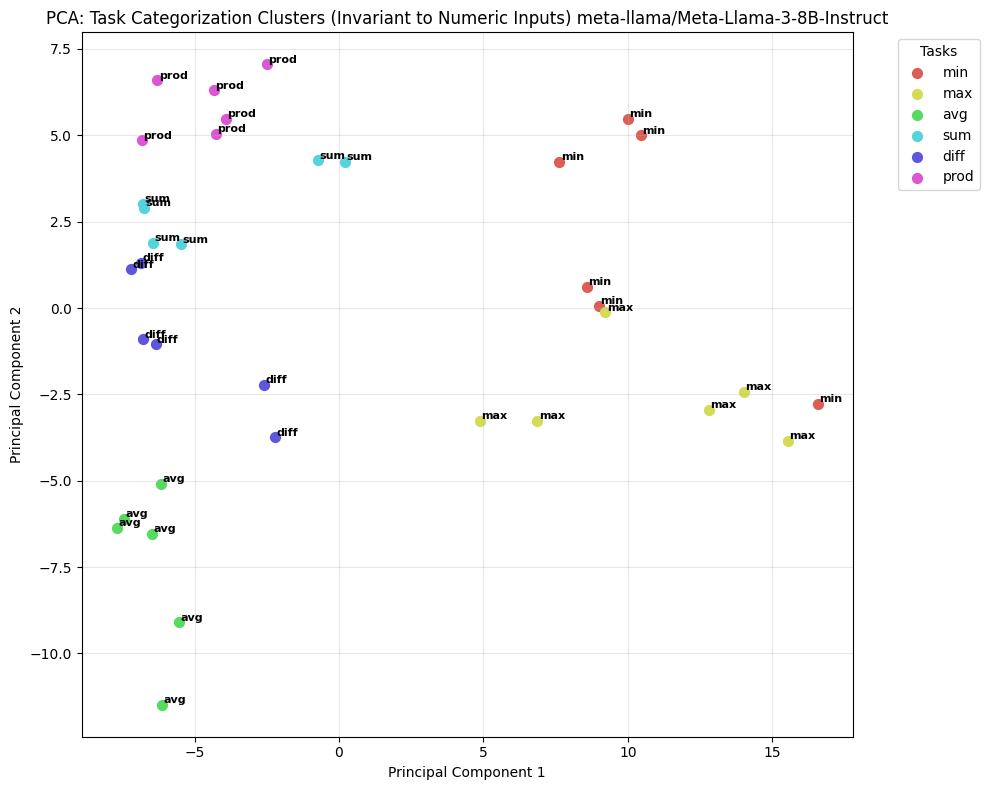

In [26]:
def visualize_pca_projection():
    pca = PCA(n_components=2)
    pca_results = pca.fit_transform(task_specific_vectors.numpy())

    plt.figure(figsize=(10, 8))
    colors = sns.color_palette("hls", len(tasks))
    task_colors = {task: colors[i] for i, task in enumerate(tasks)}

    # Create a scatter plot for each task group separately to ensure correct legend and colors
    for task_name in tasks:
        # Get indices for current task
        task_indices = [i for i, m in enumerate(metadata) if m['task'] == task_name]

        # Plot points for this task
        plt.scatter(
            pca_results[task_indices, 0],
            pca_results[task_indices, 1],
            color=task_colors[task_name],
            label=task_name, # Each task gets one legend entry
            s=50 # default size for scatter points
        )

        # Add text labels for each point for direct identification
        for idx in task_indices:
            plt.text(
                pca_results[idx, 0] + 0.05,
                pca_results[idx, 1] + 0.05,
                metadata[idx]['task'], # Label with task name
                weight='bold',
                fontsize=8 # Smaller font size to reduce clutter
            )

    plt.legend(title="Tasks", bbox_to_anchor=(1.05, 1), loc='upper left') # Move legend outside to prevent overlap
    plt.title(f"PCA: Task Categorization Clusters (Invariant to Numeric Inputs) {CG.MODEL_NAME}")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.grid(True, alpha=0.3)
    plt.tight_layout() # Adjust layout to prevent labels/legend from being cut off
    plt.show()


visualize_pca_projection()

## Step 10. The "Synonym Logit Lens" Probe

Instead of comparing residual stream vectors (which contain numbers, syntax, and intent), we should project those vectors into Vocabulary Space. If the model has categorized a prompt as "Sum," its internal state should be "thinking" about addition-related tokens long before it actually generates the answer.
- The Logic: If the model understands the category, then the residual stream at the final prompt token should have a high projection onto the entire set of synonyms for that task (e.g., for SUM: "add", "plus", "total", "sum").
- The Experiment:
  - For each task, define a Synonym Logit Set (e.g., $S_{sum} = \{add, plus, sum, total\}$).
  - At each layer $L$, take the residual stream $x_L$ at the final token position
  - Apply the model's final Unembed layer to $x_L$ to get logits.
  - Calculate a Category Score: The average logit value for all tokens in $S_{sum}$.
- Success Metric: Look for the layer where the Category Score for "Sum" spikes significantly higher than other categories, regardless of whether the prompt used the word "add" or "total."

Why this is a "Closer" approach to the Paper's logic:

- Mid-Computation Detection: Like the "Models Know" paper, this doesn't wait for the final output. It checks if the model has "internally decided" on the math operator at intermediate steps.
- Projection over Proximity: Raw vectors are messy because they represent everything at once. By using the W_U (unembedding) matrix, you are using the model's own "dictionary" to filter out numeric noise and find the specific bits of the vector that represent the Categorization Intent.
- Probing Generalization: If the score for the "Sum" category is high across all 6 prompts (even those using synonyms like "total"), it proves the existence of a shared Categorization Circuit that has mapped different inputs to a single "task space".

In [27]:
# Convert synonyms to token IDs
task_token_ids = {}
for task, syns in task_synonyms.items():
    ids = []
    for s in syns:
        # Get IDs for the word, usually with and without a leading space
        ids.extend(model.to_tokens(s, prepend_bos=False)[0].tolist())
        ids.extend(model.to_tokens(" " + s, prepend_bos=False)[0].tolist())
    task_token_ids[task] = list(set(ids))

def run_logit_lens_probe():
    results = []

    for i, prompt_data in enumerate(test_data):
        prompt = prompt_data['prompt']
        task = prompt_data['task']

        # Run model and cache residual stream
        # resid_post is the state of the stream after the layer's Attention and MLP
        logits, cache = model.run_with_cache(prompt, names_filter=lambda name: "resid_post" in name)

        for layer_idx in range(model.cfg.n_layers):
            # Extract final token activation [batch, pos, d_model] -> [d_model]
            resid_vec = cache["resid_post", layer_idx][0, -1, :]

            # Apply Logit Lens: Project residual stream directly to vocabulary
            # We use the model's unembedding matrix (W_U)
            layer_logits = resid_vec @ model.W_U

            # Calculate scores for ALL tasks to see which one is dominant
            for t_name, t_ids in task_token_ids.items():
                # Average logit of all synonyms in this category
                avg_logit = layer_logits[t_ids].mean().item()

                results.append({
                    "prompt_idx": i,
                    "task": task, # Actual ground truth task
                    "probed_category": t_name, # The category we are measuring
                    "layer": layer_idx,
                    "score": avg_logit
                })

    return pd.DataFrame(results)

# Execute Probe
df_logit_lens = run_logit_lens_probe()

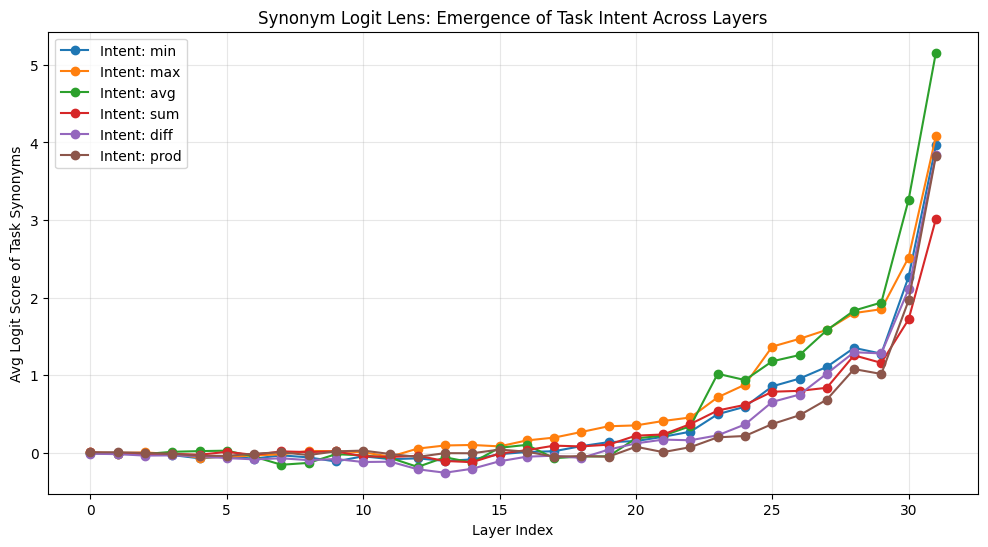

In [28]:
# Visualize: When does the "Correct" category emerge?
plt.figure(figsize=(12, 6))
for task_name in tasks:
    # Get prompts belonging to this task
    subset = df_logit_lens[(df_logit_lens['task'] == task_name) &
                          (df_logit_lens['probed_category'] == task_name)]

    # Average across the 6 examples per task
    avg_scores = subset.groupby('layer')['score'].mean()
    plt.plot(avg_scores.index, avg_scores.values, label=f"Intent: {task_name}", marker='o')

plt.title("Synonym Logit Lens: Emergence of Task Intent Across Layers")
plt.xlabel("Layer Index")
plt.ylabel("Avg Logit Score of Task Synonyms")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

**1. Reaching a "Winner-Takes-All" Consensus**
The hypothesis suggests that output selection is a "winner-takes-all" process where the activation of a Categorization Circuit acts as a gate.

- **The Late-Layer Spike:** The late layersrepresent the final refinement stage. An exponential rise in logits in these layers indicates that the model is rapidly shifting its internal state from a "superposition" of possibilities to a singular, high-confidence prediction.

- **Finalization on the Last Word:** The rise toward the end of the model suggests that these final layers are responsible for converting that high-level "intent" into specific token probabilities.

**2. The Logic of the Exponential Curve**
The exponential nature of the curve is a characteristic of the transformer's residual stream as it approaches the Unembedding Head:

- **Magnitude and Confidence:** As the model processes information through the final blocks, it increases the vector magnitude in the "task-specific direction" of the residual stream. Because logits are eventually passed through a softmax function to determine token probability, a linear increase in vector alignment in these final layers manifests as an exponential increase in logit scores.

- **Decoupling Confirmation:** As the logit scores for synonyms (e.g., "sum," "add," "total") all rise together, it suggests the model has successfully mapped the prompt into a "pure task direction" or an abstract category space that is independent of the specific phrasing used in the input.


**3. Identifying the "Categorization Layer"**
While the logits peak at layer 31, the Categorization Layer (the point of decision) is likely the layer where the separation between the ground-truth task and other tasks first becomes distinct.

Layer 25 first shows a clear gap between the correct task's logits and the other tasks' logits. This layer is likely the "Diagnostic Signal" point where the model has reached a "clear consensus" on how to proceed, effectively gating the corresponding Generation Circuit.

**4. Relation to Model Capability**
This rise indicates the model "knows what it knows" mid-computation. The fact that this occurs well before the actual output token is generated supports the Structural Separation hypothesis: the model creates a functionally distinct representation for the task category (categorization) to promote the specific logic required for the answer (generation).

In [29]:
# At what layer do categories first dominate?
best_probe_layer = 25 # Manually adjusted based on the graph above
final_scores = df_logit_lens[df_logit_lens['layer'] == best_probe_layer]

# Calculate a pivot table to see if 'Sum' prompts have the highest 'Sum' score
summary = final_scores.groupby(['task', 'probed_category'])['score'].mean().unstack()
print(f"\nCategory Confidence Matrix at Layer {best_probe_layer}:")
print(summary)

df_logit_lens = None


Category Confidence Matrix at Layer 25:
probed_category       avg      diff       max       min      prod       sum
task                                                                       
avg              1.177734  0.405599  0.387004 -0.110352  0.004065  0.585938
diff            -0.117284  0.653687  0.428263 -0.152690 -0.036856  0.383341
max             -0.125575  0.273804  1.366862  0.486003 -0.153717  0.348938
min             -0.155736  0.330526  0.909587  0.854329 -0.096076  0.344971
prod            -0.351624  0.374207  0.442708 -0.140391  0.368490  0.500977
sum             -0.067952  0.514079  0.378825 -0.097905  0.041921  0.785075


## Step 11. Gradient-Based Circuit Localization

To find the specific "Circuit" responsible for this categorization, we use Integrated Gradients. This tells us which specific components (Attention Heads or MLP neurons) are actually contributing to that "Category Score" we defined above.

**The Experiment:** Define your target "Categorization Signal" (e.g., the Logit Lens score for the "Sum" synonym set). Calculate the gradient of this signal with respect to the output of every Attention Head.

**Localize:** Identify "Intent Heads" that have high attribution to the correct category across all 6 variations of the prompt phrasing.

**Why this works:** This bypasses "similarity noise." Even if two "Sum" prompts look different in PCA, they might both be relying on the same Attention Head to "gate" the addition logic.

In [30]:
def get_gradient_based_head_attributions(target_task_name):
    # 1. Prepare Target Synonym IDs
    target_syn_ids = task_token_ids[target_task_name]

    # 2. Extract Prompts for the Target Task
    target_prompts = [d['prompt'] for d in test_data if d['task'] == target_task_name]

    # Storage for head attributions: [Layer, Head]
    total_head_attribs = torch.zeros((model.cfg.n_layers, model.cfg.n_heads))

    for prompt in target_prompts:
        # We use a clean run to get the actual activations
        logits, cache = model.run_with_cache(prompt)

        # We want the gradient of the Avg Synonym Logit at the final layer
        # with respect to the output of every attention head in the model

        for layer in range(model.cfg.n_layers):
            # hook_z is the output of the attention heads before being mixed by W_O
            # shape: [batch, pos, head, d_head]
            head_outputs = cache["z", layer]

            # For simplicity in this localization step, we calculate
            # Grad * Activation (a common approximation of Integrated Gradients)
            # which is highly effective for identifying 'heavy lifters' in circuits.

            def head_output_hook(value, hook):
                return value

            # Define the 'Categorization Signal' for backprop
            # Target the residual stream at the very last layer before Unembed
            last_resid = cache["resid_post", model.cfg.n_layers - 1][0, -1, :]

            # Calculate attribution using the model's W_U head
            # Projecting the specific head's contribution to the target synonym logits
            for head in range(model.cfg.n_heads):
                # Isolate head output and project to d_model space using W_O
                # then project to vocabulary space using W_U
                z = head_outputs[0, -1, head, :] # [d_head]
                head_contribution_to_resid = z @ model.W_O[layer, head] # [d_model]

                # Projection into synonym logit space
                head_synonym_logits = head_contribution_to_resid @ model.W_U[:, target_syn_ids]

                # Attribution Score = Average logit boost provided by this head
                total_head_attribs[layer, head] += head_synonym_logits.mean().item()

    # Average attributions across the variations of the prompt phrasing
    avg_head_attribs = total_head_attribs / len(target_prompts)
    return avg_head_attribs

In [42]:
def visualize_gradient_based_data(target_task_name, sum_attribs):
  plt.figure(figsize=(7, 4))
  sns.heatmap(sum_attribs.numpy(), cmap="RdBu_r", center=0)
  plt.title(f"Attention Head Attribution to '{target_task_name}' Category Signal")
  plt.xlabel("Head Index")
  plt.ylabel("Layer Index")
  plt.show()

def list_gradient_based_data(target_task_name, sum_attribs):
  # Identify top contributing heads
  top_values, top_indices = torch.topk(sum_attribs.flatten(), 5)
  print(f"Top 5 'Intent Heads' for {target_task_name} Categorization:")
  for val, idx in zip(top_values, top_indices):
      layer = idx.item() // model.cfg.n_heads
      head = idx.item() % model.cfg.n_heads
      print(f"Layer {layer}, Head {head}: Attribution Score {val:.4f}")

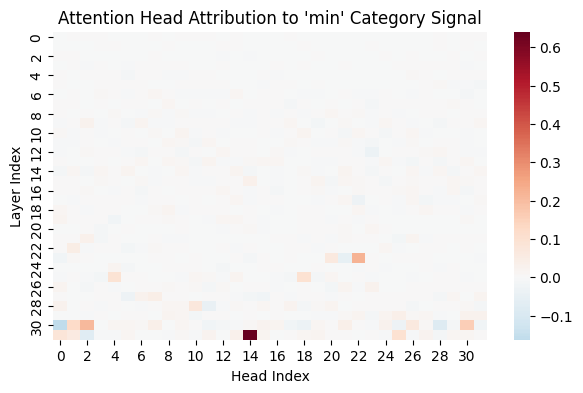

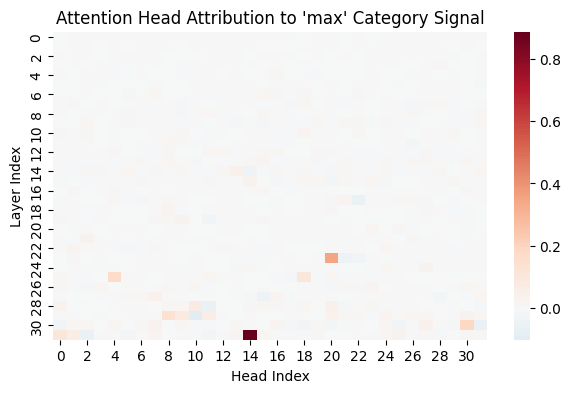

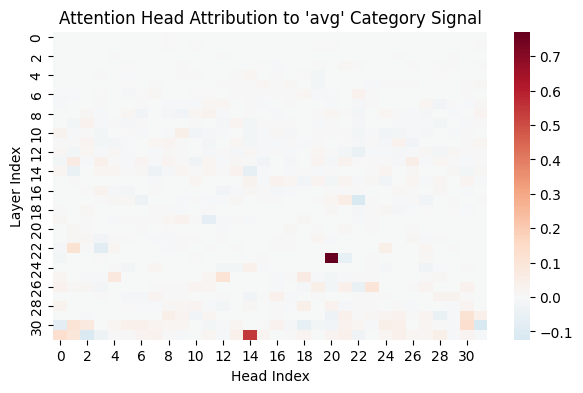

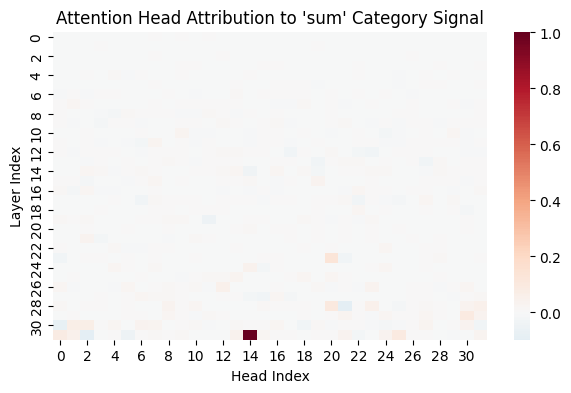

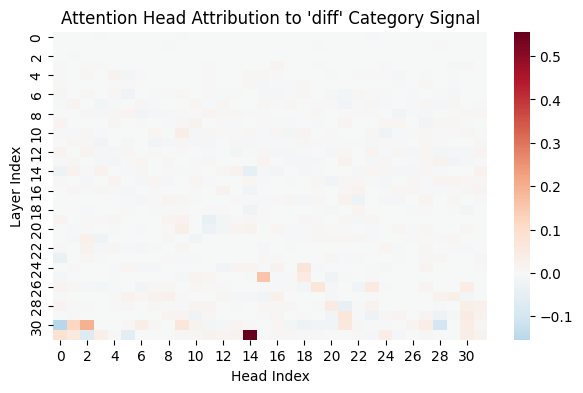

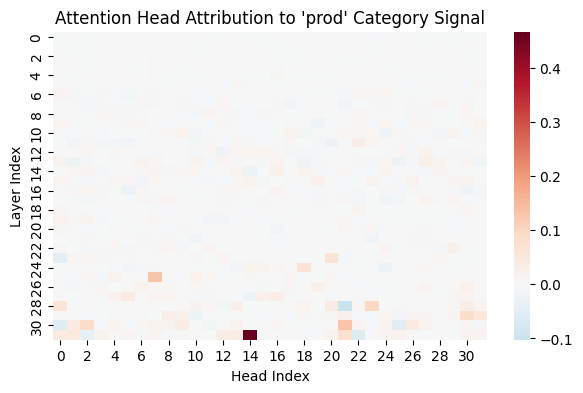

In [43]:
sum_attribs = {}

for task in tasks:
    sum_attribs[task] = get_gradient_based_head_attributions(task)
    visualize_gradient_based_data(task, sum_attribs[task])

## Step 12. Circuit Neuron overlap per task

Show the overlap between the neurons important to the various task categorization circuits. The various tasks are not randomly distributed. Instead they are heavily clustered in a few neurons.


In [44]:
# 1. Extract the top 5 heads and their scores for each task
summary_data = []
for task_name, attrib_tensor in sum_attribs.items():
    # Find top 5 values and their flattened indices
    top_values, top_indices = torch.topk(attrib_tensor.flatten(), 5)

    for val, idx in zip(top_values, top_indices):
        layer = idx.item() // model.cfg.n_heads
        head = idx.item() % model.cfg.n_heads
        summary_data.append({
            "Head": f"L{layer}.H{head}",
            "Task": task_name,
            "Score": val.item()
        })

# 2. Create a DataFrame and pivot it into a grid
df_sum = pd.DataFrame(summary_data)
grid_df = df_sum.pivot(index="Head", columns="Task", values="Score")

# 3. Order columns and rows
ordered_tasks = ['min', 'max', 'avg', 'diff', 'sum', 'prod']
grid_df = grid_df[[t for t in ordered_tasks if t in grid_df.columns]]

# Sort rows by the highest value in that row (descending)
grid_df['row_max'] = grid_df.max(axis=1)
grid_df = grid_df.sort_values(by='row_max', ascending=False).drop(columns='row_max')

# 4. Define Styling Function
def apply_color_scale(val):
    if pd.isna(val):
        return ""
    if val > 0.5:
        return 'color: red; font-weight: bold;'
    elif val > 0.25:
        return 'color: orange; font-weight: bold;'
    elif val > 0.15:
        return 'color: #D4AF37; font-weight: bold;' # Dark Yellow/Gold
    else:
        return 'color: black;'

# 5. Apply style and display
styled_grid = grid_df.style.applymap(apply_color_scale).format(lambda x: f"{x:.4f}" if pd.notna(x) else "-")

print("Polysemantic Intent Heads Attribution Grid (Sorted by Row Max):")
display(styled_grid)


Polysemantic Intent Heads Attribution Grid (Sorted by Row Max):


/tmp/ipython-input-1808157093.py:42: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_grid = grid_df.style.applymap(apply_color_scale).format(lambda x: f"{x:.4f}" if pd.notna(x) else "-")


Task,min,max,avg,diff,sum,prod
Head,,,,,,
"L31, H14",0.6403,0.8861,0.5422,0.5562,1.0025,0.4666
"L23, H20",-,0.3532,0.7716,-,0.1322,-
"L23, H22",0.2258,-,-,-,-,-
"L30, H2",0.2079,-,-,0.1959,-,0.0843
"L30, H30",0.1558,0.1847,0.1309,-,-,-
"L25, H4",-,0.1721,-,-,-,-
"L25, H15",-,-,-,0.1620,-,-
"L30, H21",-,-,-,-,-,0.1339
"L25, H7",-,-,-,-,-,0.1335


## Step 13: Analyze L31H14. TODO

Is the Layer 31 Head 14 neuron just a "mathematical intent" or does it (polysemantically) embed separate data for each task?

Consider using the "Singular Vector-Based Interpretability" technique explained in https://arxiv.org/abs/2511.20273 with code in
https://github.com/Exploration-Lab/Beyond-Components




## Step 99: Validation via Causal Intervention (Patching)

We run the model on an ambiguous prompt that doesn't specify 'sum' but add in the sum_vector. If the model gives the correct sum this is evidence that sum_vector is indeed the addition vector.